# Plot map of ICESat-2 tracks using cartopy

Uses GIBS Blue Marble with Terrain Shading (see https://nasa-gibs.github.io/gibs-api-docs/available-visualizations/)

In [14]:
pip install owslib

  Using cached OWSLib-0.32.0-py2.py3-none-any.whl.metadata (6.6 kB)
Using cached OWSLib-0.32.0-py2.py3-none-any.whl (240 kB)
Note: you may need to restart the kernel to use updated packages.


In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from cartopy.io import srtm, PostprocessedRasterSource, LocatedImage
from cartopy.io.srtm import SRTM3Source, SRTM1Source

import cartopy.io.img_tiles as cimgt

from owslib.wmts import WebMapTileService

from shapely import box, Polygon

import earthaccess

In [16]:
proj = ccrs.AlbersEqualArea(central_latitude=23., central_longitude=-96., standard_parallels=[29.5, 45.5])
extent = [-7096284.71, 7105582.09, 92407.95, 4785334.02]
colorado_extent = [-110., -102., 37., 41.]

bbox = box(-105.5,40,-105,41.)

In [17]:
result = earthaccess.search_data(
    short_name="ATL03",
    bounding_box=(-105.5,40,-105,41.),
    temporal=("2020-04-27","2020-05-28"),
    version="006",
    cloud_hosted=True,
)

Granules found: 1


In [18]:
boundary = result[0]["umm"]["SpatialExtent"]["HorizontalSpatialDomain"]["Geometry"]["GPolygons"][0]["Boundary"]["Points"]

In [19]:
boundary_poly = Polygon([point.values() for point in boundary])

/srv/conda/envs/notebook/lib/python3.10/site-packages/owslib/wmts.py:860: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if current and current.text == 'true':
/srv/conda/envs/notebook/lib/python3.10/site-packages/owslib/wmts.py:657: RuntimeWarning: TileMatrixLimits with tileMatrix "1" already exists
  warnings.warn(msg, RuntimeWarning)
/srv/conda/envs/notebook/lib/python3.10/site-packages/owslib/wmts.py:657: RuntimeWarning: TileMatrixLimits with tileMatrix "2" already exists
  warnings.warn(msg, RuntimeWarning)
/srv/conda/envs/notebook/lib/python3.10/site-packages/owslib/wmts.py:657: RuntimeWarning: TileMatrixLimits with tileMatrix "3" already exists
  warnings.warn(msg, RuntimeWarning)
/srv/conda/envs/notebook/lib/python3.10/site-packages/owslib/wmts.py:657: RuntimeWarning: TileMatrixLimits with tileMatrix "4" already exists
  warnings.warn(msg, RuntimeWarning)
/srv/conda/envs/notebook/lib/pyth

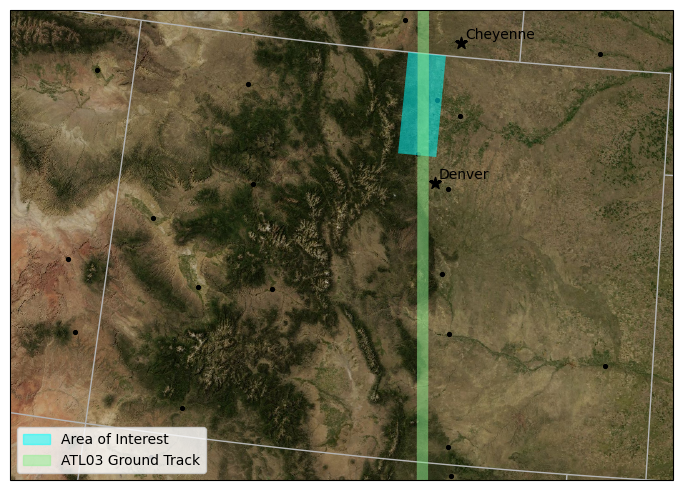

In [62]:
url = 'https://gibs.earthdata.nasa.gov/wmts/epsg4326/best/wmts.cgi'
wmts = WebMapTileService(url)

layers = ['BlueMarble_ShadedRelief']
date_str = '2020-05-15'

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none',
        edgecolor='0.7')

populated_places = cfeature.NaturalEarthFeature(category='cultural', 
                                                name='populated_places',
                                                scale='10m')

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(projection=proj)
ax.add_feature(states_provinces)  #, edgecolor='0.7')

ax.set_extent(colorado_extent, ccrs.Geodetic())

ax.add_geometries([bbox], ccrs.PlateCarree(), edgecolor=None, facecolor="cyan", alpha=0.5, label="Area of Interest")
ax.add_geometries([boundary_poly], ccrs.PlateCarree(), edgecolor=None, facecolor="lightgreen", alpha=0.5, label="ATL03 Ground Track")

ax.add_wmts(wmts, layers[0], wmts_kwargs={'time': date_str})

aoi = mpatches.Patch(color='cyan', alpha=0.5, label='Area of Interest')
footprint = mpatches.Patch(color="lightgreen", alpha=0.5, label="ATL03 Ground Track")
ax.legend(handles=[aoi, footprint], loc='lower left')

marker = [".", "*"]
annotate = [False, True]
color = ['k', 'k']
size = [30, 80]
fontsize = []

add_cities(gdf.groupby("plot_code"), marker=marker, annotate=annotate, color=color, markersize=size)

fig.tight_layout()

fig.savefig("images/atl03_ground_track_and_bbox.png")

## Load and subset Populated Places from Natural Earth

In [21]:
import cartopy.io.shapereader as shpr
import geopandas as gpd

fname = shpr.natural_earth(resolution='10m', category='cultural', name='populated_places')

gdf = gpd.read_file(fname).to_crs(ax.projection.proj4_init)  # load and convert to CRS

In [23]:
gdf = gdf[gdf.geometry.within(box(*[ax.get_extent()[i] for i in [0,2,1,3]]))]

In [32]:
gdf["plot_code"] = gdf["FEATURECLA"].isin(['Admin-1 capital', 'Admin-1 region capital', 'Admin-0 region capital', 
                                         'Admin-0 capital', 'Admin-0 capital alt'])

In [53]:
def add_cities(grouper, ax=None, marker=None, annotate=None, color=None, markersize=None, fontsize=None):
    """Adds cities and lebels by group to a plot"""

    if not ax:
        ax = plt.gca()

    ngroup = grouper.ngroups
    if not marker:
        marker = [marker] * ngroup  # Create an array of markers
    if not annotate:
        annotate = [annotate] * ngroup
    if not color:
        color = [color] * ngroup
    if not markersize:
        markersize = [markersize] * ngroup
    if not fontsize:
        fontsize = [fontsize] * ngroup

    for (name, group), mrkr, ann, c, ms, fs in zip(gdf.groupby("plot_code"), marker, annotate, color, markersize, fontsize):
        group.plot(ax=ax, marker=mrkr, color=c, markersize=ms)

        if ann:
            for x, y, label in zip(group.geometry.x, group.geometry.y, group.NAME):
                ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=fs)